# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms
from torch.autograd import Variable
import torchvision.transforms.functional as F
from PIL import Image
from skimage.transform import resize
from collections import deque, namedtuple

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="VisualBanana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


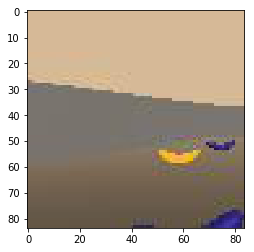

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.visual_observations[0]            # get the current state
# score = 0     
# for i in range(2):
#     while True:
#         action = np.random.randint(action_size)        # select an action
#         env_info = env.step(action)[brain_name]        # send the action to the environment
#         next_state = env_info.visual_observations[0]   # get the next state
#         reward = env_info.rewards[0]                   # get the reward
#         done = env_info.local_done[0]                  # see if episode has finished
#         score += reward                                # update the score
#         state = next_state                             # roll over the state to next time step
#         if done:                                       # exit loop if episode finished
#             break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from dqn_agent import Agent
import torch
from collections import deque
from skimage.transform import resize
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_size = 28
def process_state(x):
    x = np.squeeze(x)
    x_resize = resize(x, (image_size,image_size,3), anti_aliasing=True)
    x_modified = Variable(torch.from_numpy(x_resize).float().to(device).view(3,image_size,image_size))
    return x_modified

def process_stack(frames):
    frames_list = list(frames)
    torch_stack = torch.stack(frames_list).unsqueeze(dim=0)
    torch_stack = torch_stack.view(torch_stack.size(0),torch_stack.size(2), torch_stack.size(1), torch_stack.size(3), torch_stack.size(4) )
    return torch_stack


state_copy= []
def banana_dqn(episodes_num=5000, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995, seed =0):
    scores = []
    score_window = deque(maxlen=100)
    epsilon = epsilon_start
    max_score = 7.0
    count = 5
    for episode in range(1, episodes_num+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.visual_observations[0]            # get the current state
        score = 0
        stack_ready = False
        frame_stack= deque()
        stack_count = 0
        stack_size = 3
        is_state_processed = False
        while True:
#             state = resize(state, (state.shape[0],32, 32, 3), anti_aliasing=True)
            if not is_state_processed: 
                state = process_state(state)
            if len(frame_stack) < stack_size:
                
                for i in range(stack_size):
                    frame_stack.append(state)
                # for the first items just copy the times all at once
            else:
                frame_stack.popleft()
                frame_stack.append(state)
            processed_stack = process_stack(frame_stack)
            action = agent.act(processed_stack, epsilon)        # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.visual_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            next_state = process_state(next_state) # resize(next_state, (state.shape[0],32, 32, 3), anti_aliasing=True)
            
            next_fram_stack = frame_stack.copy()
            next_fram_stack.popleft()
            next_fram_stack.append(next_state)
            
            agent.step(state=processed_stack, action=action, reward=reward, next_state=process_stack(next_fram_stack), done=done, stack_size=stack_size)
            
            state = next_state 
            is_state_processed = True
            
            
            if done:
                # exit loop if episode finished
                break
            state_copy.append((state, action))
            count -= 1
            
        score_window.append(score)
        scores.append(score)
        epsilon = max(epsilon_min, epsilon*epsilon_decay)

        print('\rEpisode: {}\tAverage Score: {:.2f}'.format(episode, np.mean(score_window)), end="")
        if episode % 100 == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}'.format(episode, np.mean(score_window)))
        if np.mean(score_window)>= max_score:
            torch.save(agent.QN_local.state_dict(), 'checkpoint_pixels.pth')
            break
        
    return scores

seed = 0
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])
print('Action Size:{}, State Size:{}'.format(action_size, state_size))
agent = Agent(state_size, action_size, seed = seed, training = True, pixels = True, lr=0.001)
scores = banana_dqn(seed = seed)
torch.save(agent.QN_local.state_dict(), 'checkpoint_pixels.pth')

Action Size:4, State Size:0
loaded cnn network


/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Episode: 100	Average Score: 0.14
Episode: 200	Average Score: 0.66
Episode: 300	Average Score: 1.97
Episode: 400	Average Score: 2.35
Episode: 500	Average Score: 3.29
Episode: 600	Average Score: 4.37
Episode: 700	Average Score: 5.35
Episode: 800	Average Score: 5.23
Episode: 900	Average Score: 4.66
Episode: 1000	Average Score: 6.21
Episode: 1100	Average Score: 6.34
Episode: 1193	Average Score: 7.07

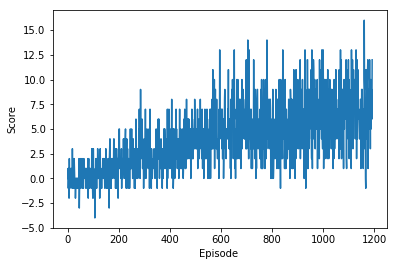

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.xlabel('Episode ')
plt.ylabel('Score')
plt.show()

In [ ]:
# Testing network

# import torch
# import torch.nn as nn
# import torch.nn.functional as Fun
# from torchvision import transforms
# from collections import OrderedDict

# class QNetwork(nn.Module):
#     def __init__(self, state_size, action_size, seed, training ):
#         super(QNetwork, self).__init__()

#         self.c1=nn.Conv3d(in_channels = 3,  out_channels=10, kernel_size=(1,5,5) , stride=1)
#         self.r1 = nn.ReLU()
#         self.max1 = nn.MaxPool3d((1,2,2))
        
#         # (32-5+ 0)/1 + 1 -> 28x28x10 -> 14x14x10
#         self.c2 = nn.Conv3d(in_channels=10, out_channels=32, kernel_size=(1,5,5) , stride=1)
#         self.r2 = nn.ReLU()
#         self.max2 = nn.MaxPool3d((1,2,2))
            
#         # 14-5 +1 -> 5x5x32 
#         self.fc4 = nn.Linear(5*5*32*3, action_size)
# #         self.r4 = nn.ReLU()
# #         self.fc5 = nn.Linear(84, action_size)
    
#     def forward(self, img_stack):
#         print('-',img_stack.size())
#         output = self.c1(img_stack)
        
#         output = self.r1(output)
#         output = self.max1(output)
#         print('*',output.size())
        
#         output = self.c2(output)
#         output = self.r2(output)
#         output = self.max2(output)
#         print('**',output.size())
        
#         output = output.view(output.size(0), -1)
#         print('***', output.size())
#         output = self.fc4(output)
#         return output

In [6]:
# Testing stack

# # plt.imshow(np.squeeze(state_resize), cmap='gray')
# # plt.show()

# q = QNetwork(state_size = 0, action_size= 4, seed = 0, training= True)

# # model_params = list(q.parameters())
# # model_params_len = len(model_params)
# # for i in range(model_params_len):
# #     print(model_params[i].size())
    
    
# # transform=torchvision.transforms.Compose([
# #                        Stack()]))

# frame_stack= []
# for i in range(3):
#     env_info = env.reset(train_mode=True)[brain_name] # reset the environment
#     state = np.squeeze(env_info.visual_observations[0])
#     print(state.shape)
#     state_resize = resize(state, (32,32,3), anti_aliasing=True)
#     state_modified = Variable(torch.from_numpy(state_resize).float().to('cpu').view(3,32,32))
#     frame_stack.append(state_modified)

# np_stack = torch.stack(frame_stack).unsqueeze(dim=0)
# print(np_stack.shape)
# np_stack = np_stack.view(np_stack.size(0),np_stack.size(2), np_stack.size(1), np_stack.size(3), np_stack.size(4) )
# print(np_stack.shape)
# q.eval()
# action = q(np_stack)
# q.train()
# print(len(action))
# action_q = int(np.argmax(action[-1].cpu().data.numpy()))
# action_picked = action_q
# print(action_picked)
    
# #     next_state = env_info.visual_observations[0]   # get the next state
# #     reward = env_info.rewards[0]                   # get the reward
# #     done = env_info.local_done[0] 

#        # select an action
# # env_info = env.step(action_picked)[brain_name]        # send the action to the environment
#                  # see if episode has finished

# # see if episode has finished
# # next_state_resize = resize(next_state, (1, 64, 64,3), anti_aliasing=True)

# # plt.imshow(np.squeeze(state_resize), cmap='gray')
# # plt.show()

# # plt.imshow(np.squeeze(next_state_resize), cmap='gray')
# # plt.show()